## Sirius/LNLS - Scientific Computing Group
## Ptychography

This notebook contains an example on how to call Ptychography using sscCdi

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py

import sscCdi
print(f'sscCdi version: {sscCdi.__version__}')

sscCdi version: 0.10.0


### Load example data

In [2]:
data = np.load('../data/ptycho/data.npy')
positions = np.load('../data/ptycho/positions.npy')

### Define initial object and initial probe, if wanted

In [3]:
initial_obj = None
initial_probe = None

### Ptychography. The following algorithms are available:

    - ePIE_python: Extended Ptychographic Iterative Engine. Single GPU, Python implementation using CuPy
    - RAAR_python: Relaxed Averaged Alternating Reflections. Single GPU, Python implementation using CuPy
    - ePIE:   Extended Ptychographic Iterative Engine. Single GPU, CUDA implementation
    - RAAR:   Relaxed Averaged Alternating Reflections. Multi GPU, CUDA implementation
    - AP:     Alternate Projections. Multi GPU, CUDA implementation
    - AP_PC:  Alternate Projections with Position Correction via Annealing method. Multi GPU, CUDA implementation

### Inputs:
    - DPs (ndarray): diffraction data with shape (N,Y,X). N is the number of diffraction patterns.
    - positions (array): positions array with shape (N,2) with (x,y) position pairs in each line.
    - initial_obj (ndarray, optional): Initial guess for object. Shape to be determined from DPs and positions. If None, will use the input in "input_dict" to determine the initial object. Defaults to None.
    - initial_probe (ndarray, optional): Initial guess for probe of shape (M,Y,X), where M is the number of probe modes. If None, will use the input in "input_dict" to determine the initial probe. Defaults to None.
    - input_dict (dict): dictionary of input required for Ptychography. See dicitonary of inputs in the next cell for details.
    

### Returns:
    - obj: object matrix 
    - probe: probe matrix
    - error: error metric along iterations
    - positions: final positions of the scan (which may be corrected if AP_PC_CUDA is used)


In [4]:
input_dict = {

    "hdf5_output": './output.h5', # path to hdf5 file to contain all outputs
    
    'CPUs': 32,  # number of cpus to use in parallel execution    
    'GPUs': [0], # list of numbers (e.g. [0,1,2]) containg the number of the GPUs

    "fresnel_regime": False, # only available for Python engines
    
    'energy': 6, # energy in keV
    
    'detector_distance': 13, # meters
    
    'distance_sample_focus': 0, # float. Distance in meters between sample and focus or pinhole. This distance is used to propagated the probe prior to application of the probe support. 
    
    'detector_pixel_size': 55e-6, # meters
    
    'binning': 1, # how many times to bin data. Must be even number. if 1, no binning occurs.
    
    'position_rotation': 0, # angle in radians. Rotation applied to the positions for correcting angle between detector and probe transverse coordinates

    'object_padding': 0, # pixels. Number of pixels to add around the object matrix

    'incoherent_modes': 1, # int. Number of incoherent modes to use.

    'probe_support': {"type": "circular",  "radius": 100,  "center_y": 0, "center_x": 0} , # support to be applied to the probe matrix after probe update. Options are:
                                                                                           # - {"type": "circular",  "radius": 300,  "center_y": 0, "center_x": 0} (0,0) is the center of the image
                                                                                           # - {"type": "cross",  "center_width": 300,  "cross_width": 0, "border_padding": 0} 
                                                                                           # - {"type": "array",  "data": myArray}

    
    "initial_obj": {"obj": 'random'},     # 2d array. Initial guess for the object. Options are:
                                          # - {"obj": my2darray}, numpy array 
                                          # - {"obj": 'path/to/numpyFile.npy'}, path to .npy, 
                                          # - {"obj": 'path/to/hdf5File.h5'}, path to .hdf5 of previous recon containing the reconstructed object in 'recon/object'
                                          # - {"obj": 'random'}, random matrix with values between 0 and 1
                                          # - {"obj": 'constant'}, constant matrix of 1s

    'initial_probe': { "probe": 'inverse'},   # 2d array. Initial guess for the probe. Options are:
                                              # - {"probe": my2darray}, numpy array 
                                              # - {"probe": 'path/to/numpyFile.npy'}, path to .npy, 
                                              # - {"probe": 'path/to/hdf5File.h5'}, path to .hdf5 of previous recon containing the reconstructed object in 'recon/object'
                                              # - {"probe": 'random'}, random matrix with values between 0 and 1
                                              # - {"probe": 'constant'}, constant matrix of 1s
                                              # - {"probe": 'inverse'}, matrix of the Inverse Fourier Transform of the mean of DPs.
                                              # - {"probe": 'circular', "radius": 100, "distance":0},  circular mask with a pixel of "radius". If a distance (in meters) is given, it propagated the round probe using the ASM method 
                                              # { "probe": 'fzp', 
                                                # 'beam_type': 'disc',  # 'disc' or 'gaussian'                 
                                                # 'distance_sample_fzpf': 2.9e-3, # distance between sample and fzp focus        
                                                # 'fzp_diameter': 50e-6,               
                                                # 'fzp_outer_zone_width': 50e-9,     
                                                # 'beamstopper_diameter': 20e-6,  # beamstopper placed before fzp. if 0, no beamstopper used      
                                                # 'probe_diameter': 50e-6, # if not included, will use the same diameter s the fzp
                                                # 'probe_normalize':False},  # normalizes fzp probe at end        
    

'algorithms': {
    
    
# '1': {'name': 'RAAR_python',
#         'iterations': 50,
#         'beta': 0.9,
#         'regularization_object': 0.01,
#         'regularization_probe': 0.01,
#         'step_object': 1.0,
#         'step_probe': 1.0,
#         },

# '1': {'name': 'ePIE_python',
#         'iterations': 50,
#         'regularization_object': 0.25,
#         'regularization_probe': 0.5,
#         'step_object': 0.5,
#         'step_probe': 1,
#         'use_mPIE': False,
#         'mPIE_friction_obj': 0.9,
#         'mPIE_friction_probe': 0.99,
#         'mPIE_momentum_counter': 10,
#         },    


# '3': {'name': 'ML_python',
#         'optimizer': 'gradient_descent',
#         'iterations': 200,
#         'step_object': 0.000001,
#         'step_probe': 0.000001,
#         },        

    
'1': {'name':'RAAR',
     'batch': 64,
     'iterations': 100, 
     'beta': 0.9,
     'step_object': 1.0,
     'step_probe': 1.0,   
     'regularization_object': 0.01,
     'regularization_probe': 0.01,
     'momentum_obj': 0.0,
     'momentum_probe': 0.0,
     'position_correction': 0,
     },   
    
'2': {'name':'AP',
     'batch': 64,
     'iterations': 50, 
     'step_object': 1.0,
     'step_probe': 1.0,   
     'regularization_object': 0.01,
     'regularization_probe': 0.01,
     'momentum_obj': 0.5,
     'momentum_probe': 0.5, 
     'position_correction': 0,
     },   
    
'3': {'name':'PIE',
     'iterations': 50, 
     'step_object': 1.0,
     'step_probe': 1.0,   
     'regularization_object': 0.5,
     'regularization_probe': 0.5,
     'momentum_obj': 0.5,
     'momentum_probe': 0.5, 
     'position_correction': 0,
     }, 

}

}


Data shape: (81, 160, 160)
Initial probe shape: (160, 160)
Estimated size for 81 DPs of type float64: 1.34 GBs
Pixel size = 55.00 um
Energy = 6 keV
Wavelength = 0.207 nm
Object pixel = 305.26 nm
Object shape: (315, 323)


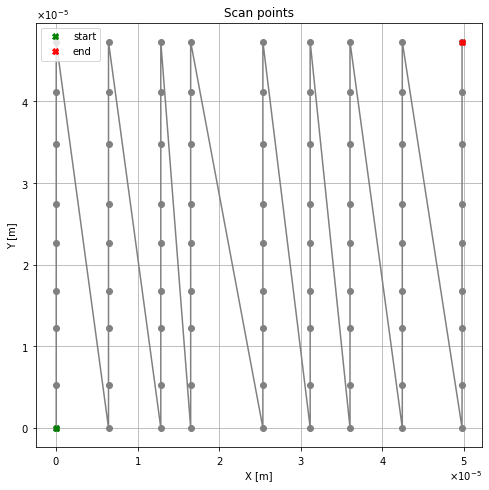

Creating output hdf5 file...
Creating initial probe...
Probe shape (160,160) with 1 incoherent mode(s)
Creating initial object...
Plotting initial guesses...


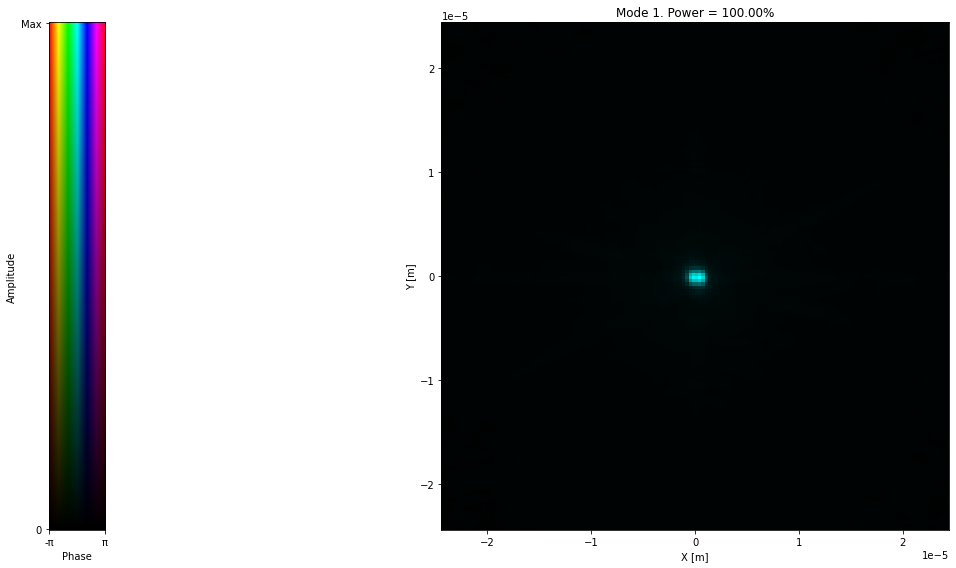

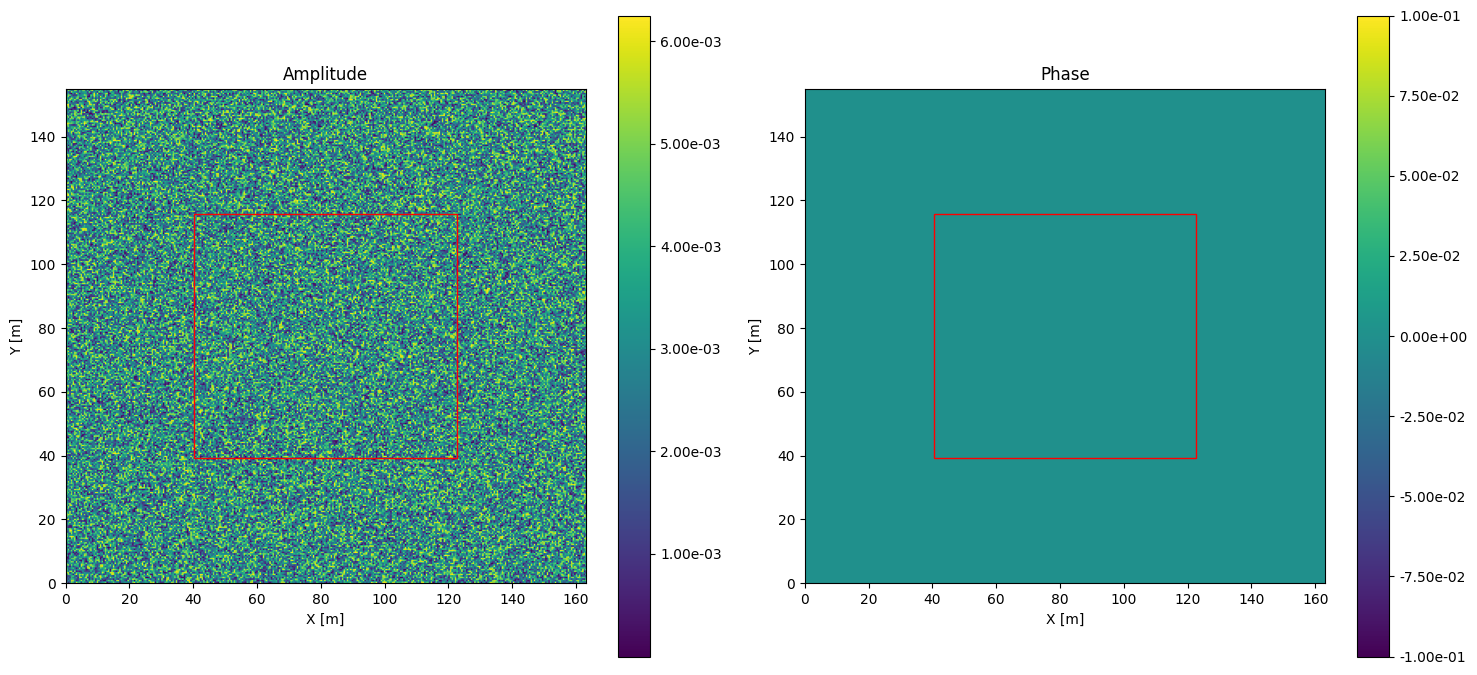

Setting probe support...


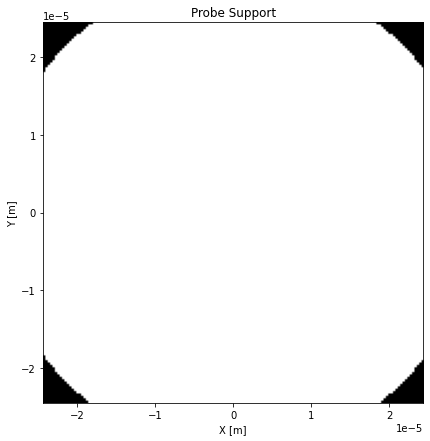

Distance between sample and focus: 0.0mm. Corresponding Fresnel number: 0
Total datapack size: 0.02 GBs
Starting ptychography... using 1 GPUs [0] and 32 CPUs
Calling 50 iterations of RAAR algorithm...
	Iteration 50/50 	Error: 6.49e+21

Plotting final object and probe...


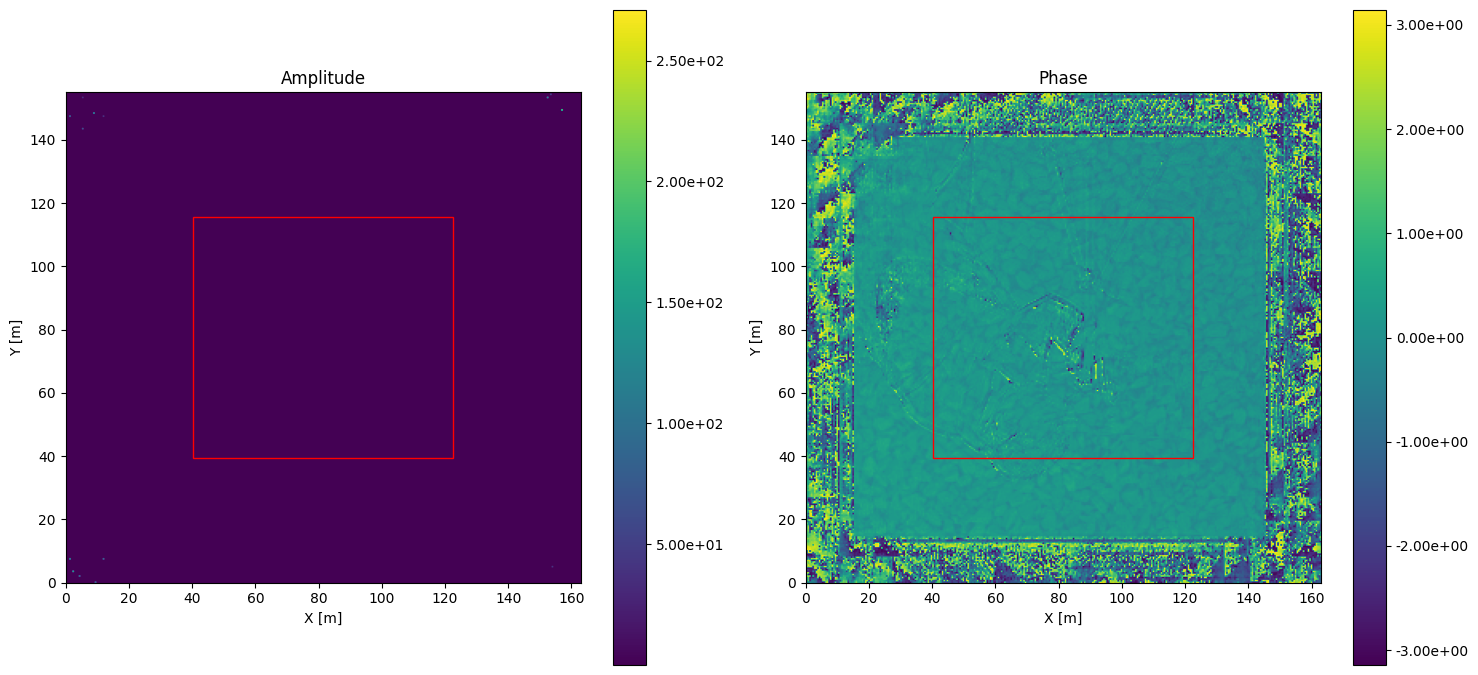

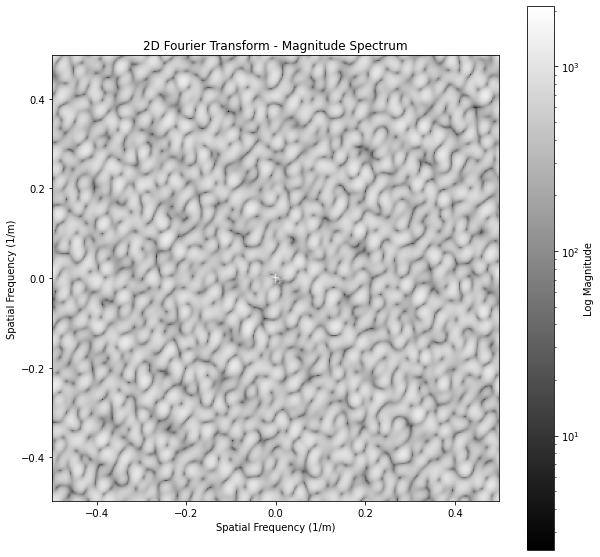

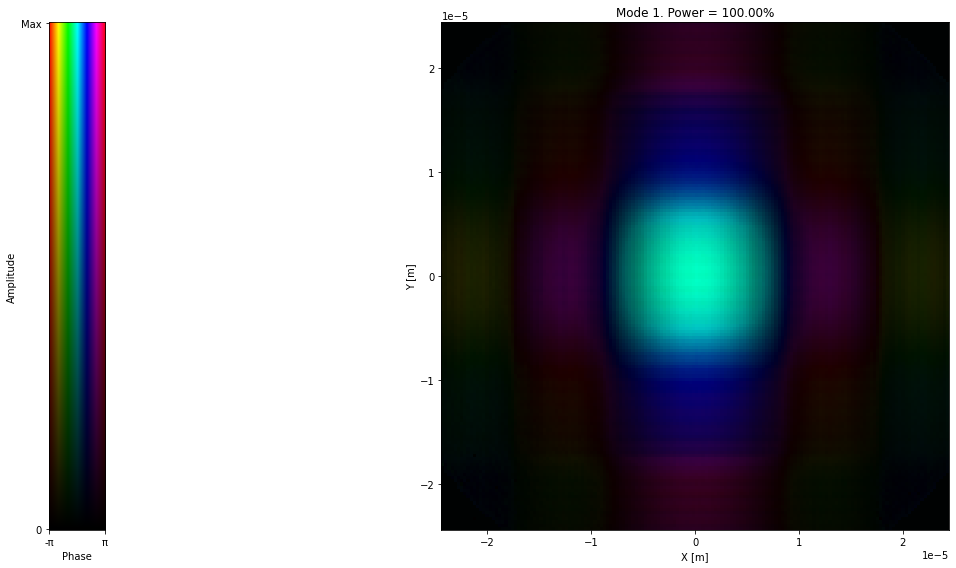

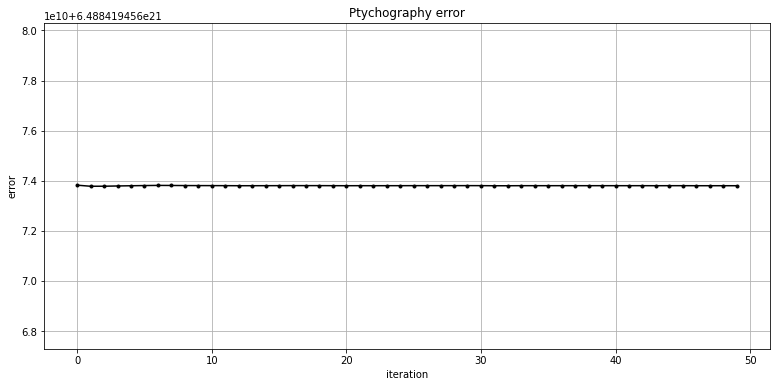

Saving output hdf5 file...


In [5]:
%matplotlib inline
recon_obj, recon_probe, recon_positions, metadata, recon_error = sscCdi.call_ptychography(input_dict.copy(),data, positions, initial_obj=initial_obj, initial_probe=initial_probe)

In [6]:
sscCdi.ptycho.plots.plot_objects_interactive(np.expand_dims(recon_obj,axis=0), positions=positions+recon_probe[0].shape[-1]//2,extent=sscCdi.ptycho.plots.get_plot_extent_from_positions(positions))

interactive(children=(IntSlider(value=0, description='Probe Index', max=0), Output()), _dom_classes=('widget-i…

In [7]:
sscCdi.ptycho.plots.plot_probe_modes_interactive(np.log(recon_probe+1),extent=sscCdi.ptycho.plots.get_extent_from_pixel_size(recon_probe[0].shape,metadata["object_pixel"]))

interactive(children=(IntSlider(value=0, description='Probe Index', max=0), Output()), _dom_classes=('widget-i…

FloatSlider(value=0.0, continuous_update=False, description='z (mm)', max=15.0, min=-15.0, step=0.5)

FloatRangeSlider(value=(1.117065020286163e+21, 5.613512084753667e+22), continuous_update=False, description='M…

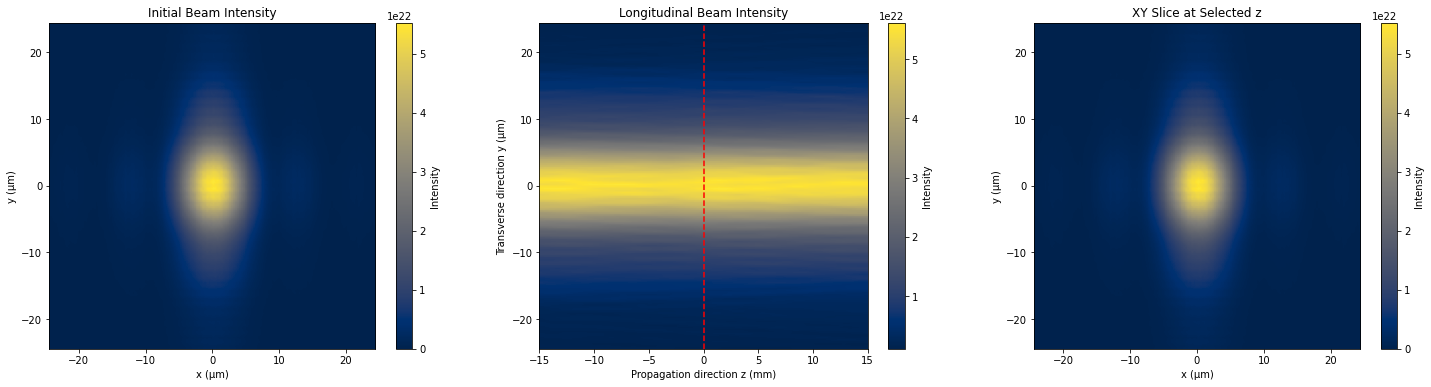

In [8]:
dz = 5e-4  # Step size in propagation direction in meters
z_range = 15e-3  # Range of propagation in meters
sscCdi.ptycho.plots.plot_caustic(recon_probe[0],metadata['wavelength'], dz, z_range, metadata['object_pixel'],direction='vertical')